In [31]:
import pandas as pd
import datetime
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [3]:
stock = pd.read_csv('MSFT.csv')
stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060163,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062311,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063386,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061774,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060700,47894400
...,...,...,...,...,...,...,...
9593,2024-04-08,425.170013,427.279999,423.299988,424.589996,424.589996,14272400
9594,2024-04-09,426.440002,427.739990,421.619995,426.279999,426.279999,12512300
9595,2024-04-10,422.190002,424.029999,419.700012,423.260010,423.260010,16216600
9596,2024-04-11,425.820007,429.369995,422.359985,427.929993,427.929993,17966400


In [4]:
stock.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
stock.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
duplicate_rows = stock[stock.duplicated()]

if duplicate_rows.empty:
    print("No duplicate rows found.")
else:
    print("Duplicate rows:")
    print(duplicate_rows)

No duplicate rows found.


In [11]:
def str_to_datetime(s):
    split = s.split('-')
    y, m, d = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=y, month=m, day=d)

In [12]:
stock1 = stock[['Date', 'Close']]
stock1

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9593,2024-04-08,424.589996
9594,2024-04-09,426.279999
9595,2024-04-10,423.260010
9596,2024-04-11,427.929993


In [13]:
stock1['Date'] = stock1['Date'].apply(str_to_datetime)
stock1['Date']

C:\Users\surya\AppData\Local\Temp\ipykernel_15236\87997201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock1['Date'] = stock1['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9593   2024-04-08
9594   2024-04-09
9595   2024-04-10
9596   2024-04-11
9597   2024-04-12
Name: Date, Length: 9598, dtype: datetime64[ns]

In [14]:
stock1.index = stock1.pop('Date')
stock1

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-04-08,424.589996
2024-04-09,426.279999
2024-04-10,423.260010


In [15]:
import matplotlib.pyplot as plt

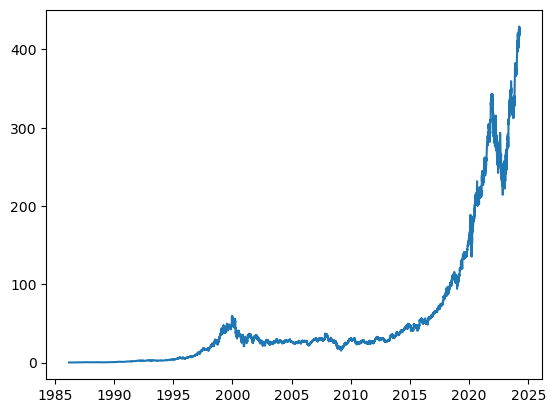

In [23]:
plt.plot(stock1.index, stock1['Close'])


In [28]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(stock1, 
                                '1986-03-18', 
                                '2024-04-12', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1986-03-18,0.097222,0.100694,0.102431,0.099826
1,1986-03-19,0.100694,0.102431,0.099826,0.098090
2,1986-03-20,0.102431,0.099826,0.098090,0.095486
3,1986-03-21,0.099826,0.098090,0.095486,0.092882
4,1986-03-24,0.098090,0.095486,0.092882,0.090278
...,...,...,...,...,...
9590,2024-04-08,420.450012,417.880005,425.519989,424.589996
9591,2024-04-09,417.880005,425.519989,424.589996,426.279999
9592,2024-04-10,425.519989,424.589996,426.279999,423.260010
9593,2024-04-11,424.589996,426.279999,423.260010,427.929993


In [29]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((9595,), (9595, 3, 1), (9595,))

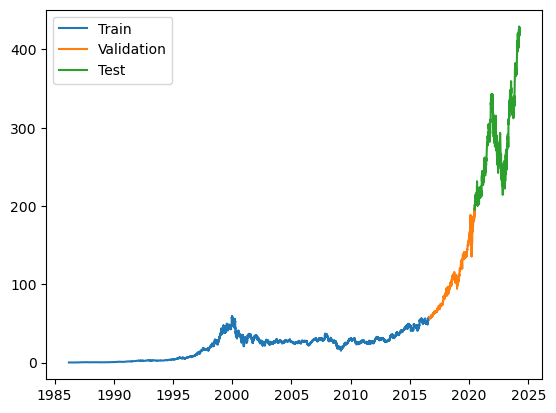

In [30]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [32]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


Epoch 1/100


240/240 [==============================] - 4s 6ms/step - loss: 104.6410 - mean_absolute_error: 4.3902 - val_loss: 4157.8652 - val_mean_absolute_error: 51.5769
Epoch 2/100
240/240 [==============================] - 1s 4ms/step - loss: 0.3580 - mean_absolute_error: 0.3495 - val_loss: 3897.6189 - val_mean_absolute_error: 49.1406
Epoch 3/100
240/240 [==============================] - 1s 3ms/step - loss: 0.3481 - mean_absolute_error: 0.3495 - val_loss: 3794.7261 - val_mean_absolute_error: 48.2662
Epoch 4/100
240/240 [==============================] - 1s 4ms/step - loss: 0.3589 - mean_absolute_error: 0.3570 - val_loss: 3752.2107 - val_mean_absolute_error: 47.8873
Epoch 5/100
240/240 [==============================] - 1s 3ms/step - loss: 0.3246 - mean_absolute_error: 0.3340 - val_loss: 3711.5952 - val_mean_absolute_error: 47.6058
Epoch 6/100
240/240 [==============================] - 1s 4ms/step - loss: 0.3519 - mean_absolute_error: 0.3511 - val_loss: 3681.1157 - val_mean_absol

240/240 [==============================] - 1s 3ms/step - loss: 0.3651 - mean_absolute_error: 0.3667 - val_loss: 3101.5908 - val_mean_absolute_error: 43.2714
Epoch 46/100
240/240 [==============================] - 1s 3ms/step - loss: 0.3223 - mean_absolute_error: 0.3357 - val_loss: 3092.4851 - val_mean_absolute_error: 42.9299
Epoch 47/100
240/240 [==============================] - 1s 3ms/step - loss: 0.3185 - mean_absolute_error: 0.3309 - val_loss: 3043.5149 - val_mean_absolute_error: 42.2366
Epoch 48/100
240/240 [==============================] - 1s 4ms/step - loss: 0.3129 - mean_absolute_error: 0.3340 - val_loss: 2990.3066 - val_mean_absolute_error: 41.6639
Epoch 49/100
240/240 [==============================] - 1s 4ms/step - loss: 0.3441 - mean_absolute_error: 0.3542 - val_loss: 3000.8198 - val_mean_absolute_error: 41.7440
Epoch 50/100
240/240 [==============================] - 1s 4ms/step - loss: 0.3503 - mean_absolute_error: 0.3543 - val_loss: 3033.2292 - val_mean_absolute_error: 4

240/240 [==============================] - 1s 3ms/step - loss: 0.3313 - mean_absolute_error: 0.3407 - val_loss: 3056.3413 - val_mean_absolute_error: 42.0117
Epoch 94/100
240/240 [==============================] - 1s 3ms/step - loss: 0.3223 - mean_absolute_error: 0.3318 - val_loss: 3135.7344 - val_mean_absolute_error: 42.9448
Epoch 95/100
240/240 [==============================] - 1s 3ms/step - loss: 0.3056 - mean_absolute_error: 0.3210 - val_loss: 3165.9624 - val_mean_absolute_error: 43.5105
Epoch 96/100
240/240 [==============================] - 1s 3ms/step - loss: 0.3078 - mean_absolute_error: 0.3237 - val_loss: 3039.7686 - val_mean_absolute_error: 41.8316
Epoch 97/100
240/240 [==============================] - 1s 3ms/step - loss: 0.3112 - mean_absolute_error: 0.3285 - val_loss: 3117.7446 - val_mean_absolute_error: 42.9429
Epoch 98/100
240/240 [==============================] - 1s 3ms/step - loss: 0.3070 - mean_absolute_error: 0.3227 - val_loss: 3075.2715 - val_mean_absolute_error: 4

240/240 [==============================] - 1s 2ms/step


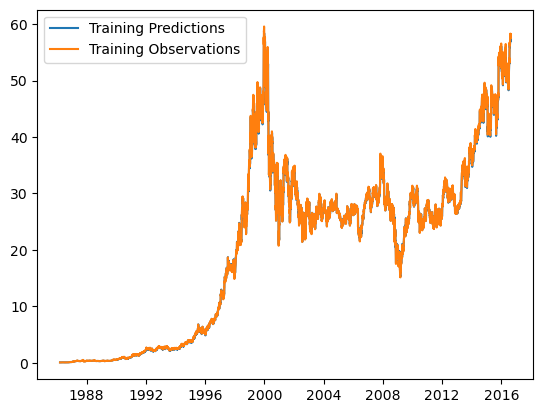

In [33]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

30/30 [==============================] - 0s 2ms/step


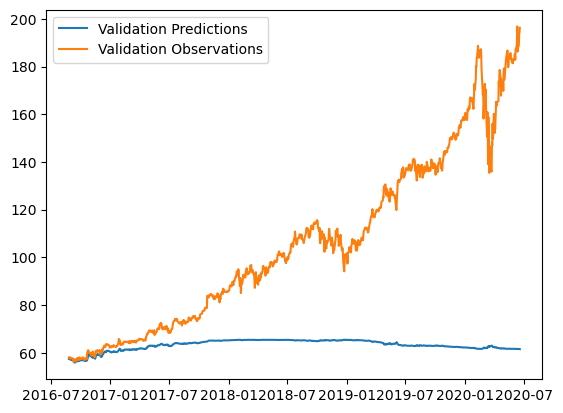

In [34]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

30/30 [==============================] - 0s 2ms/step


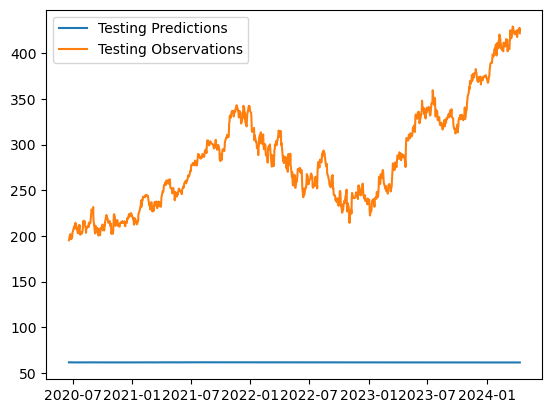

In [35]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

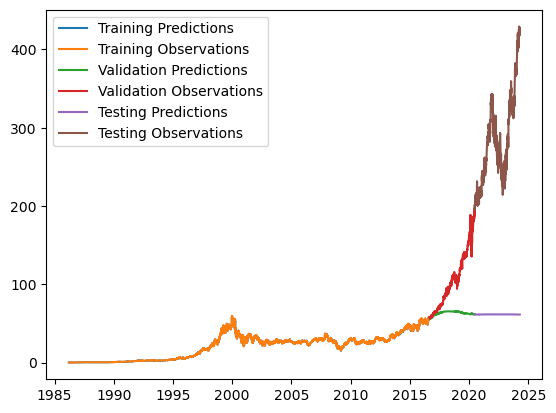

In [68]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [69]:
windowed_df1 = df_to_windowed_df(stock1, 
                                '2023-04-17', 
                                '2024-04-12', 
                                n=3)
windowed_df1

,Target Date,Target-3,Target-2,Target-1,Target
0,2023-04-17,283.489990,289.839996,286.140015,288.799988
1,2023-04-18,289.839996,286.140015,288.799988,288.369995
2,2023-04-19,286.140015,288.799988,288.369995,288.450012
3,2023-04-20,288.799988,288.369995,288.450012,286.109985
4,2023-04-21,288.369995,288.450012,286.109985,285.760010
...,...,...,...,...,...
245,2024-04-08,420.450012,417.880005,425.519989,424.589996
246,2024-04-09,417.880005,425.519989,424.589996,426.279999
247,2024-04-10,425.519989,424.589996,426.279999,423.260010
248,2024-04-11,424.589996,426.279999,423.260010,427.929993


In [70]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates1, X1, y1 = windowed_df_to_date_X_y(windowed_df1)

dates1.shape, X1.shape, y1.shape

((250,), (250, 3, 1), (250,))

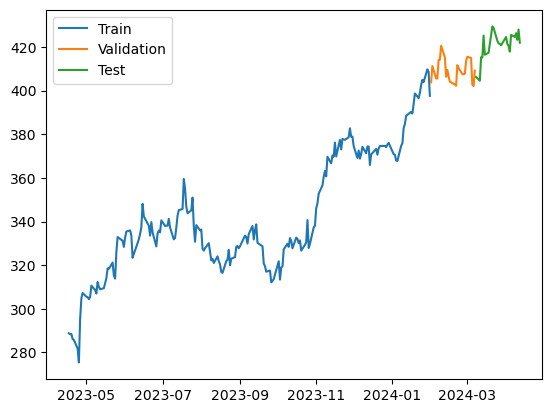

In [71]:
q_80 = int(len(dates1) * .8)
q_90 = int(len(dates1) * .9)

dates_train1, X_train1, y_train1 = dates1[:q_80], X1[:q_80], y1[:q_80]

dates_val1, X_val1, y_val1 = dates1[q_80:q_90], X1[q_80:q_90], y1[q_80:q_90]
dates_test1, X_test1, y_test1 = dates1[q_90:], X1[q_90:], y1[q_90:]

plt.plot(dates_train1, y_train1)
plt.plot(dates_val1, y_val1)
plt.plot(dates_test1, y_test1)

plt.legend(['Train', 'Validation', 'Test'])

In [72]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(75),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(16, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=200)

Epoch 1/200
7/7 [==============================] - 3s 85ms/step - loss: 116407.4688 - mean_absolute_error: 340.0518 - val_loss: 165554.5625 - val_mean_absolute_error: 406.8542
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 115471.2422 - mean_absolute_error: 338.6756 - val_loss: 164256.2188 - val_mean_absolute_error: 405.2556
Epoch 3/200
7/7 [==============================] - 0s 9ms/step - loss: 114255.8203 - mean_absolute_error: 336.8740 - val_loss: 162519.3750 - val_mean_absolute_error: 403.1069
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 112592.0625 - mean_absolute_error: 334.3889 - val_loss: 160025.8750 - val_mean_absolute_error: 400.0021
Epoch 5/200
7/7 [==============================] - 0s 11ms/step - loss: 110053.3438 - mean_absolute_error: 330.5706 - val_loss: 155867.0156 - val_mean_absolute_error: 394.7693
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 106028.2109 - mean_absolute_error: 324.4327 - val_

Epoch 49/200
7/7 [==============================] - 0s 8ms/step - loss: 443.3327 - mean_absolute_error: 17.1517 - val_loss: 2447.2859 - val_mean_absolute_error: 49.2423
Epoch 50/200
7/7 [==============================] - 0s 9ms/step - loss: 438.6942 - mean_absolute_error: 17.2560 - val_loss: 2947.3003 - val_mean_absolute_error: 54.0866
Epoch 51/200
7/7 [==============================] - 0s 8ms/step - loss: 393.4615 - mean_absolute_error: 15.8277 - val_loss: 2539.1130 - val_mean_absolute_error: 50.1726
Epoch 52/200
7/7 [==============================] - 0s 7ms/step - loss: 390.6476 - mean_absolute_error: 15.6963 - val_loss: 1585.5665 - val_mean_absolute_error: 39.5381
Epoch 53/200
7/7 [==============================] - 0s 9ms/step - loss: 530.7132 - mean_absolute_error: 19.5302 - val_loss: 3629.2778 - val_mean_absolute_error: 60.0663
Epoch 54/200
7/7 [==============================] - 0s 7ms/step - loss: 581.7611 - mean_absolute_error: 20.5031 - val_loss: 4825.4268 - val_mean_absolute_e

Epoch 98/200
7/7 [==============================] - 0s 12ms/step - loss: 28.8526 - mean_absolute_error: 4.1694 - val_loss: 97.3375 - val_mean_absolute_error: 8.7874
Epoch 99/200
7/7 [==============================] - 0s 8ms/step - loss: 30.3040 - mean_absolute_error: 4.3294 - val_loss: 100.2229 - val_mean_absolute_error: 8.9389
Epoch 100/200
7/7 [==============================] - 0s 9ms/step - loss: 33.0084 - mean_absolute_error: 4.3638 - val_loss: 60.2159 - val_mean_absolute_error: 6.5261
Epoch 101/200
7/7 [==============================] - 0s 7ms/step - loss: 61.4083 - mean_absolute_error: 6.4960 - val_loss: 197.5733 - val_mean_absolute_error: 13.2315
Epoch 102/200
7/7 [==============================] - 0s 8ms/step - loss: 52.8499 - mean_absolute_error: 5.9492 - val_loss: 275.7432 - val_mean_absolute_error: 15.8895
Epoch 103/200
7/7 [==============================] - 0s 8ms/step - loss: 44.6878 - mean_absolute_error: 5.1456 - val_loss: 198.5498 - val_mean_absolute_error: 13.2522
Epoc

7/7 [==============================] - 0s 8ms/step - loss: 43.1866 - mean_absolute_error: 5.4235 - val_loss: 25.4142 - val_mean_absolute_error: 4.0872
Epoch 148/200
7/7 [==============================] - 0s 9ms/step - loss: 58.1700 - mean_absolute_error: 6.3464 - val_loss: 120.4105 - val_mean_absolute_error: 9.9075
Epoch 149/200
7/7 [==============================] - 0s 10ms/step - loss: 55.4170 - mean_absolute_error: 6.1365 - val_loss: 142.5059 - val_mean_absolute_error: 10.8877
Epoch 150/200
7/7 [==============================] - 0s 10ms/step - loss: 32.9837 - mean_absolute_error: 4.4692 - val_loss: 86.5299 - val_mean_absolute_error: 8.1632
Epoch 151/200
7/7 [==============================] - 0s 9ms/step - loss: 26.7525 - mean_absolute_error: 4.1261 - val_loss: 28.7745 - val_mean_absolute_error: 4.2475
Epoch 152/200
7/7 [==============================] - 0s 9ms/step - loss: 36.0799 - mean_absolute_error: 4.7925 - val_loss: 37.4426 - val_mean_absolute_error: 4.8657
Epoch 153/200
7/7 [

7/7 [==============================] - 0s 10ms/step - loss: 23.9710 - mean_absolute_error: 3.8105 - val_loss: 30.9319 - val_mean_absolute_error: 4.3507
Epoch 197/200
7/7 [==============================] - 0s 10ms/step - loss: 27.6432 - mean_absolute_error: 4.1610 - val_loss: 86.0960 - val_mean_absolute_error: 8.1671
Epoch 198/200
7/7 [==============================] - 0s 10ms/step - loss: 36.9407 - mean_absolute_error: 4.8052 - val_loss: 79.9792 - val_mean_absolute_error: 7.8302
Epoch 199/200
7/7 [==============================] - 0s 8ms/step - loss: 30.3835 - mean_absolute_error: 4.4118 - val_loss: 37.0267 - val_mean_absolute_error: 4.8142
Epoch 200/200
7/7 [==============================] - 0s 9ms/step - loss: 29.0406 - mean_absolute_error: 4.3982 - val_loss: 23.7607 - val_mean_absolute_error: 3.9826


7/7 [==============================] - 0s 3ms/step


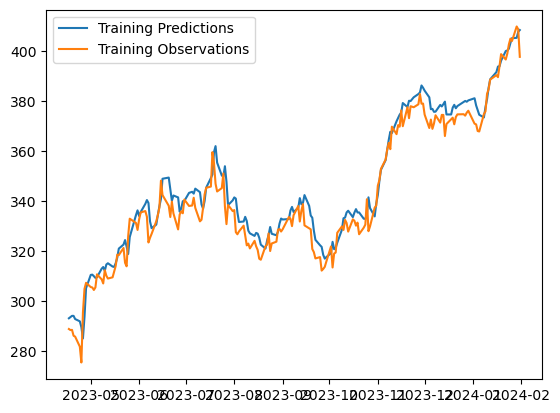

In [73]:
train_predictions1 = model.predict(X_train1).flatten()

plt.plot(dates_train1, train_predictions1)
plt.plot(dates_train1, y_train1)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 16ms/step


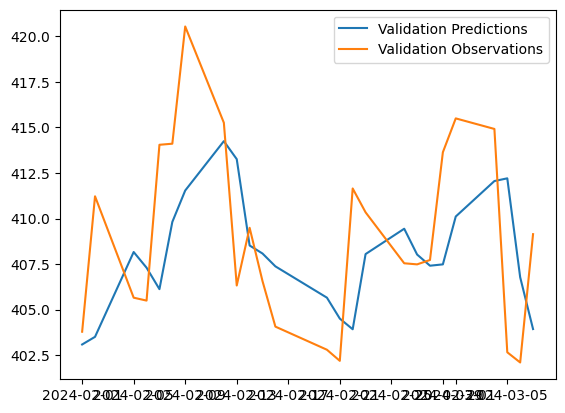

In [74]:
val_predictions1 = model.predict(X_val1).flatten()

plt.plot(dates_val1, val_predictions1)
plt.plot(dates_val1, y_val1)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 28ms/step


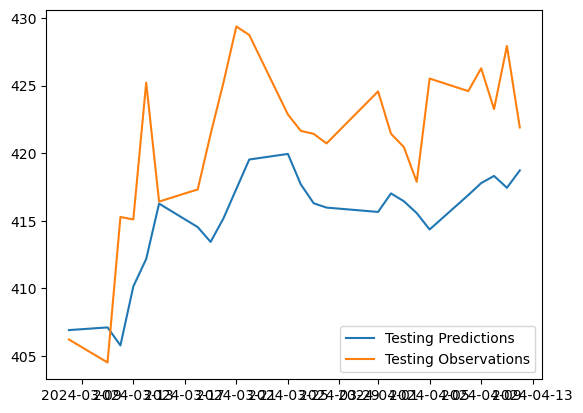

In [75]:
test_predictions1 = model.predict(X_test1).flatten()

plt.plot(dates_test1, test_predictions1)
plt.plot(dates_test1, y_test1)
plt.legend(['Testing Predictions', 'Testing Observations'])

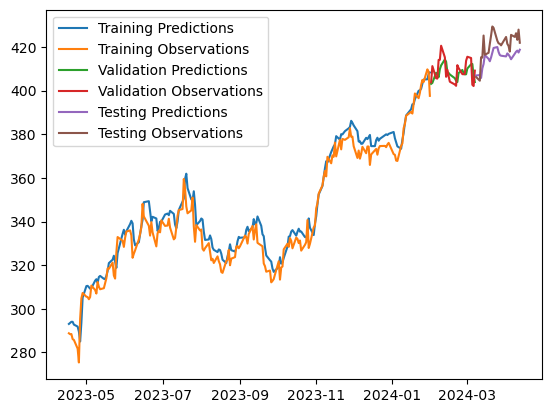

In [76]:
plt.plot(dates_train1, train_predictions1)
plt.plot(dates_train1, y_train1)
plt.plot(dates_val1, val_predictions1)
plt.plot(dates_val1, y_val1)
plt.plot(dates_test1, test_predictions1)
plt.plot(dates_test1, y_test1)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [77]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val1, dates_test1])

for target_date in recursive_dates:
  last_window = deepcopy(X_train1[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 23ms/step


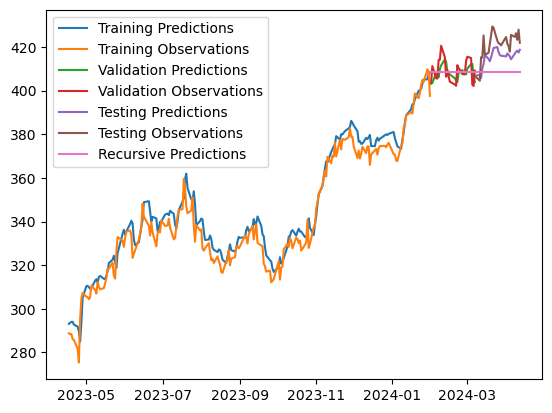

In [78]:
plt.plot(dates_train1, train_predictions1)
plt.plot(dates_train1, y_train1)
plt.plot(dates_val1, val_predictions1)
plt.plot(dates_val1, y_val1)
plt.plot(dates_test1, test_predictions1)
plt.plot(dates_test1, y_test1)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])